In [23]:
# Change the current working directory to the parent directory
%cd ..

# Load the autoreload extension, which allows automatic reloading of modules
%load_ext autoreload

# Set autoreload mode to 2: automatically reload all modules before executing a cell
%autoreload 2



/Users
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Standard library imports
import uuid  # For generating unique identifiers
import os, getpass  # For interacting with the operating system and getting the current user

# Third-party or custom library import (assumed to be your internal library)
import open_deep_research  # Custom package for research tools
# print(open_deep_research.__version__)  # Print the current version of the custom package

# IPython utilities for displaying images and markdown in notebooks
from IPython.display import Image, display, Markdown

# LangGraph utility for in-memory checkpointing of graph state
from langgraph.checkpoint.memory import MemorySaver

# Import a utility to build multi-agent supervisors from the open_deep_research package
# from open_deep_research.multi_agent import supervisor_builder


import os  # Standard-library interface to the operating system; here we read env-vars for overrides 
from enum import Enum  # Base class for defining enumerations (fixed sets of symbolic names) 
from dataclasses import dataclass, fields, field  # @dataclass decorator and helpers that auto-generate boilerplate & introspection utilities
from typing import Any, Optional, Dict, Literal  # Static-typing primitives: unconstrained Any, nullable Optional, mapping Dict, and value-restricted Literal 
from langchain_core.runnables import RunnableConfig  # LangChain object for per-run overrides, tagging, callbacks, etc.


In [25]:

DEFAULT_REPORT_STRUCTURE = """Use this structure to create a report on the user-provided topic:

1. Introduction (no research needed)
   - Brief overview of the topic area

2. Main Body Sections:
   - Each section should focus on a sub-topic of the user-provided topic
   
3. Conclusion
   - Aim for 1 structural element (either a list or table) that distills the main body sections 
   - Provide a concise summary of the report"""  # Triple-quoted constant string serving as a default outline template

class SearchAPI(Enum):  # Enumeration listing every search backend the agents can call 
    PERPLEXITY = "perplexity"   # Use Perplexity.ai’s API for web-search 
    TAVILY = "tavily"           # Tavily (LLM-augmented) search service identifier
    EXA = "exa"                 # Exa semantic code / web search engine
    ARXIV = "arxiv"             # arXiv scientific-paper search endpoint
    PUBMED = "pubmed"           # PubMed biomedical literature search
    LINKUP = "linkup"           # (Project-specific) LinkUp knowledge base
    DUCKDUCKGO = "duckduckgo"   # Privacy-centric DuckDuckGo search engine
    GOOGLESEARCH = "googlesearch"  # Classic Google Search
    NONE = "none"               # Sentinel meaning “skip external search”

@dataclass(kw_only=True)  # Convert class into a dataclass; all fields must be passed by keyword (kw_only=True) 
class MultiAgentConfiguration:
    """Configuration for the multi-agent implementation (multi_agent.py)."""
    # ── Common configuration ────────────────────────────────────────────
    search_api: SearchAPI = SearchAPI.TAVILY  # Which SearchAPI enum variant to use by default
    search_api_config: Optional[Dict[str, Any]] = None  # Extra auth/params for the chosen API (or None)
    process_search_results: Literal["summarize", "split_and_rerank"] | None = None  # Post-process strategy constrained by Literal :contentReference[oaicite:9]{index=9}
    summarization_model_provider: str = "anthropic"  # Vendor that hosts the summarizer model
    summarization_model: str = "claude-3-5-haiku-latest"  # Concrete summarization checkpoint (Claude Haiku) :contentReference[oaicite:10]{index=10}
    include_source_str: bool = False  # Whether to append verbatim sources in the final answer
    
    # ── Multi-agent specific settings ───────────────────────────────────
    number_of_queries: int = 2  # How many search queries each agent should craft per report section
    supervisor_model: str = "anthropic:claude-3-7-sonnet-latest"  # LLM used by the supervisor agent
    researcher_model: str = "anthropic:claude-3-7-sonnet-latest"  # LLM used by the researcher agent
    ask_for_clarification: bool = False  # If True, agents may ask the end-user follow-up questions
    # MCP (Multi-Capability-Platform) integration
    # TODO
    mcp_server_config: Optional[Dict[str, Any]] = None  # Connection details for an external MCP server
    mcp_prompt: Optional[str] = None  # Custom system prompt to send when delegating to MCP
    mcp_tools_to_include: Optional[list[str]] = None  # Explicit list of tool names MCP should expose
    
    @classmethod  # Marks the following method as operating on the class, not an instance
    def from_runnable_config(
        cls, config: Optional[RunnableConfig] = None  # Accept an optional LangChain RunnableConfig for per-call overrides
    ) -> "MultiAgentConfiguration":  # Return type hint (a new MultiAgentConfiguration)
        """Create a MultiAgentConfiguration instance from a RunnableConfig."""
        configurable = (  # Pull the `.configurable` dict if present; else fall back to `{}` :contentReference[oaicite:11]{index=11}
            config["configurable"] if config and "configurable" in config else {}
        )
        values: dict[str, Any] = {  # Assemble candidate override values
            f.name: os.environ.get(f.name.upper(), configurable.get(f.name))  # Prefer ENV_VAR > runtime config > default 
            for f in fields(cls)  # Iterate over dataclass Field objects for this class 
            if f.init  # Skip any field that was excluded from auto-generated __init__
        }
        return cls(**{k: v for k, v in values.items() if v})  # Instantiate with only non-None overrides


In [26]:
def get_config_value(value):
    """
    Helper function to handle string, dict, and enum cases of configuration values
    """
    if isinstance(value, str):
        return value
    elif isinstance(value, dict):
        return value
    else:
        return value.value

In [27]:
# Import LangSmith's `traceable` decorator to log this function's inputs/outputs for observability
from langsmith import traceable

# Import Tavily's asynchronous client for making non-blocking API calls
from tavily import AsyncTavilyClient

# Import Python's built-in async I/O library
import asyncio

# Mark the function as `traceable` so LangSmith can track it in logs or traces
@traceable
# Define an asynchronous function for concurrently searching multiple queries using Tavily
async def tavily_search_async(
    search_queries,  # A list of search strings to run
    max_results: int = 5,  # Maximum number of search results to retrieve per query
    topic: Literal["general", "news", "finance"] = "general",  # Optional topic category to filter results
    include_raw_content: bool = True  # Whether to include full page content in the results
):
    """
    Performs concurrent web searches with the Tavily API.

    Args:
        search_queries (List[str]): List of search queries to process.
        max_results (int): Max number of results to retrieve per query.
        topic (Literal["general", "news", "finance"]): Filter results by category.
        include_raw_content (bool): Whether to include full text of webpages.

    Returns:
        List[dict]: One result per query, each a dictionary containing:
            - 'query': The original search query.
            - 'follow_up_questions': Always None (placeholder).
            - 'answer': Always None (placeholder).
            - 'images': A list of related images.
            - 'results': A list of search result objects, each with:
                - 'title': Title of the page.
                - 'url': Link to the result.
                - 'content': A short snippet/summary.
                - 'score': Relevance score from Tavily.
                - 'raw_content': Full content (if requested).
    """ #NOTE: This is in this shape cause of future states...

    # Instantiate the asynchronous Tavily API client
    tavily_async_client = AsyncTavilyClient()

    # Create an empty list to hold all the coroutine tasks
    search_tasks = []

    # Loop over each query and create a coroutine to search it
    for query in search_queries:
        search_tasks.append(
            tavily_async_client.search(
                query,  # The search string
                max_results=max_results,  # Limit on results
                include_raw_content=include_raw_content,  # Whether to fetch full content
                topic=topic  # Filter by topic category
            )
        )
        # Note: These tasks are created but not yet executed

    # Run all search coroutines concurrently and wait for them to finish
    search_docs = await asyncio.gather(*search_tasks)

    # Return the list of results — one per original query
    return search_docs


In [28]:
SUMMARIZATION_PROMPT = """You are tasked with summarizing the raw content of a webpage retrieved from a web search. Your goal is to create a concise summary that preserves the most important information from the original web page. This summary will be used by a downstream research agent, so it's crucial to maintain the key details without losing essential information.

Here is the raw content of the webpage:

<webpage_content>
{webpage_content}
</webpage_content>

Please follow these guidelines to create your summary:

1. Identify and preserve the main topic or purpose of the webpage.
2. Retain key facts, statistics, and data points that are central to the content's message.
3. Keep important quotes from credible sources or experts.
4. Maintain the chronological order of events if the content is time-sensitive or historical.
5. Preserve any lists or step-by-step instructions if present.
6. Include relevant dates, names, and locations that are crucial to understanding the content.
7. Summarize lengthy explanations while keeping the core message intact.

When handling different types of content:

- For news articles: Focus on the who, what, when, where, why, and how.
- For scientific content: Preserve methodology, results, and conclusions.
- For opinion pieces: Maintain the main arguments and supporting points.
- For product pages: Keep key features, specifications, and unique selling points.

Your summary should be significantly shorter than the original content but comprehensive enough to stand alone as a source of information. Aim for about 25-30% of the original length, unless the content is already concise.

Present your summary in the following format:

```
{{
   "summary": "Your concise summary here, structured with appropriate paragraphs or bullet points as needed",
   "key_excerpts": [
     "First important quote or excerpt",
     "Second important quote or excerpt",
     "Third important quote or excerpt",
     ...Add more excerpts as needed, up to a maximum of 5
   ]
}}
```

Here are two examples of good summaries:

Example 1 (for a news article):
```json
{{
   "summary": "On July 15, 2023, NASA successfully launched the Artemis II mission from Kennedy Space Center. This marks the first crewed mission to the Moon since Apollo 17 in 1972. The four-person crew, led by Commander Jane Smith, will orbit the Moon for 10 days before returning to Earth. This mission is a crucial step in NASA's plans to establish a permanent human presence on the Moon by 2030.",
   "key_excerpts": [
     "Artemis II represents a new era in space exploration," said NASA Administrator John Doe.
     "The mission will test critical systems for future long-duration stays on the Moon," explained Lead Engineer Sarah Johnson.
     "We're not just going back to the Moon, we're going forward to the Moon," Commander Jane Smith stated during the pre-launch press conference.
   ]
}}
```

Example 2 (for a scientific article):
```json
{{
   "summary": "A new study published in Nature Climate Change reveals that global sea levels are rising faster than previously thought. Researchers analyzed satellite data from 1993 to 2022 and found that the rate of sea-level rise has accelerated by 0.08 mm/year² over the past three decades. This acceleration is primarily attributed to melting ice sheets in Greenland and Antarctica. The study projects that if current trends continue, global sea levels could rise by up to 2 meters by 2100, posing significant risks to coastal communities worldwide.",
   "key_excerpts": [
      "Our findings indicate a clear acceleration in sea-level rise, which has significant implications for coastal planning and adaptation strategies," lead author Dr. Emily Brown stated.
      "The rate of ice sheet melt in Greenland and Antarctica has tripled since the 1990s," the study reports.
      "Without immediate and substantial reductions in greenhouse gas emissions, we are looking at potentially catastrophic sea-level rise by the end of this century," warned co-author Professor Michael Green.
   ]
}}
```

Remember, your goal is to create a summary that can be easily understood and utilized by a downstream research agent while preserving the most critical information from the original webpage."""

In [29]:
# ----- Imports -----
from langchain_core.language_models import BaseChatModel   # Abstract base for any LangChain chat model
from langchain_anthropic import ChatAnthropic              # Concrete wrapper for Claude models (Anthropic)
from pydantic import BaseModel                              # For type-checked, schema-validated data classes


# ----- Pydantic schema describing the LLM’s expected JSON output -----
class Summary(BaseModel):
    summary: str            # Concise paragraph-style summary of the page
    key_excerpts: list[str] # Up to 5 important quotes or snippets


# ----- Async helper that calls the LLM and returns a formatted summary -----
async def summarize_webpage(model: BaseChatModel, webpage_content: str) -> str:
    """
    Summarize raw webpage text with any LangChain chat model.

    Args:
        model (BaseChatModel): An initialized LangChain chat model
                              (OpenAI, Anthropic, Llama.cpp, etc.).
        webpage_content (str): The full text of the webpage to summarize.

    Returns:
        str: XML-like block containing <summary> and <key_excerpts> tags,
             or, on failure, the raw webpage_content.
    """
    try:
        # ---- 1. Craft the user message in provider-specific format ----
        user_input_content = "Please summarize the article"

        # Anthropic’s Claude expects the content of a USER message to be a
        # *list of blocks* (each with a "type") rather than a plain string.
        if isinstance(model, ChatAnthropic):
            user_input_content = [{
                "type": "text",
                "text": user_input_content,
                # Optional metadata telling Claude this block may be cached
                "cache_control": {"type": "ephemeral", "ttl": "1h"}
            }]

        # ---- 2. Call the model with:
        #       • Structured-output enforcement (Pydantic schema)
        #       • Automatic retry if output doesn’t match the schema
        #       • Async invocation (.ainvoke) ----------------------------
        summary: Summary = await (
            model
            .with_structured_output(Summary)          # Force JSON matching Summary
            .with_retry(stop_after_attempt=2)         # Retry twice on validation error
            .ainvoke(                                 # Async call with system+user messages
                [
                    {
                        "role": "system",
                        "content": SUMMARIZATION_PROMPT.format(
                            webpage_content=webpage_content
                        )
                    },
                    {"role": "user", "content": user_input_content},
                ]
            )
        )

    except Exception:
        # If the LLM call fails (network, validation, etc.),
        # return the raw HTML/text so downstream logic still has something.
        return webpage_content

    # ---- 3. Convert the validated Summary object into the desired markup ----
    def format_summary(summary: Summary) -> str:
        # Bullet-format each excerpt
        excerpts_str = "\n".join(f"- {e}" for e in summary.key_excerpts)
        # Wrap summary and excerpts in XML-style tags
        return (
            f"<summary>\n{summary.summary}\n</summary>\n\n"
            f"<key_excerpts>\n{excerpts_str}\n</key_excerpts>"
        )

    return format_summary(summary)


In [30]:
# ----- Imports -----
from langchain_core.embeddings import Embeddings  # Abstract base class for any embedding model (e.g., OpenAI, HuggingFace)
from langchain_core.documents import Document     # Standard container for text chunks + metadata used across LangChain
from langchain_text_splitters import RecursiveCharacterTextSplitter  # Smart text splitter that respects structure (paragraphs/sentences)
from langchain_core.vectorstores import InMemoryVectorStore          # Temporary in-memory vector DB for similarity search

# ----- Function to split and semantically re-rank web search results -----
def split_and_rerank_search_results(
    embeddings: Embeddings,           # A LangChain-compatible embedding model (e.g., OpenAIEmbeddings)
    query: str,                       # Natural language query used for similarity search
    search_results: list[dict],      # List of web search result dicts containing 'raw_content', 'url', 'title'
    max_chunks: int = 5              # Max number of top-ranked text chunks to return
):
    # Step 1: Set up a text splitter that breaks long documents into overlapping chunks (~1500 characters each)
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1500,          # Ideal chunk size (approx. token-safe for most LLMs)
        chunk_overlap=200,        # Overlap to preserve context across chunks
        add_start_index=True      # Annotates chunks with start positions (optional but useful for tracing)
    )

    # Step 2: Wrap raw web content into LangChain Document objects with metadata
    documents = [
        Document(
            page_content=result.get('raw_content') or result['content'],  # Use full text if available, else fallback to summary
            metadata={"url": result['url'], "title": result['title']}     # Attach source metadata (for provenance)
        )
        for result in search_results
    ]

    # Step 3: Split all documents into smaller chunks using the recursive splitter
    all_splits = text_splitter.split_documents(documents)

    # Step 4: Initialize an in-memory vector store using the given embedding model
    vector_store = InMemoryVectorStore(embeddings)

    # Step 5: Embed and index all split chunks into the vector store
    vector_store.add_documents(documents=all_splits)

    # Step 6: Perform semantic similarity search using the input query
    retrieved_docs = vector_store.similarity_search(query, k=max_chunks)

    # Step 7: Return the top-k most relevant text chunks as LangChain Documents (with original metadata)
    return retrieved_docs


In [31]:
from collections import defaultdict  # Provides dictionaries with automatic default values
import hashlib                      # Used to create hash values for deduplication
from typing import List, Optional, Dict, Any, Union, Literal, Annotated, cast  # Type hinting utilities

# ---- Function to merge chunks by URL, removing duplicates and stitching them into a single Document per page ----
def stitch_documents_by_url(documents: list[Document]) -> list[Document]:
    # Group all chunks by their source URL (one list of Document objects per URL)
    url_to_docs: defaultdict[str, list[Document]] = defaultdict(list)

    # Keep a set of content hashes for each URL to avoid storing duplicate chunks
    url_to_snippet_hashes: defaultdict[str, set[str]] = defaultdict(set)

    # Iterate through all input Document chunks
    for doc in documents:
        # Generate a SHA-256 hash of the text content — acts as a unique fingerprint
        snippet_hash = hashlib.sha256(doc.page_content.encode()).hexdigest()

        # Extract the source URL from the document's metadata
        url = doc.metadata['url']

        # If this content has already been seen for this URL, skip it (duplicate)
        if snippet_hash in url_to_snippet_hashes[url]:
            continue

        # Otherwise, record this chunk under the URL and save its hash
        url_to_docs[url].append(doc)
        url_to_snippet_hashes[url].add(snippet_hash)

    # ---- Stitch together chunks belonging to the same URL ----
    stitched_docs = []  # Final output: one stitched Document per unique URL

    for docs in url_to_docs.values():
        # Join all chunks from this URL with spacing and visual separators ("...")
        stitched_doc = Document(
            page_content="\n\n".join([f"...{doc.page_content}..." for doc in docs]),

            # Reuse metadata from the first chunk — assumes all chunks share the same metadata like URL and title
            metadata=cast(Document, docs[0]).metadata
        )
        stitched_docs.append(stitched_doc)  # Add the stitched document to the result list

    # Return the list of deduplicated, stitched documents — one per unique URL
    return stitched_docs


In [32]:
from langchain_core.tools import tool
from typing import List, Optional, Dict, Any, Union, Literal, Annotated, cast
from langchain_core.tools import InjectedToolArg
from langchain.chat_models import init_chat_model
from langchain.embeddings import init_embeddings
import itertools

TAVILY_SEARCH_DESCRIPTION = (
    "A search engine optimized for comprehensive, accurate, and trusted results. "
    "Useful for when you need to answer questions about current events."
)

@tool(description=TAVILY_SEARCH_DESCRIPTION)
async def tavily_search(
    queries: List[str],
    max_results: Annotated[int, InjectedToolArg] = 5,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
    config: RunnableConfig = None
) -> str:
    """
    Fetches results from Tavily search API.

    Args:
        queries (List[str]): List of search queries
        max_results (int): Maximum number of results to return
        topic (Literal['general', 'news', 'finance']): Topic to filter results by

    Returns:
        str: A formatted string of search results
    """
    # Use tavily_search_async with include_raw_content=True to get content directly
    search_results = await tavily_search_async(
        queries,
        max_results=max_results,
        topic=topic,
        include_raw_content=True
    )

    # Format the search results directly using the raw_content already provided
    formatted_output = f"Search results: \n\n"
    
    # Deduplicate results by URL
    unique_results = {}
    for response in search_results:
        for result in response['results']:
            url = result['url']
            if url not in unique_results:
                unique_results[url] = {**result, "query": response['query']}

    async def noop():
        return None

    configurable = MultiAgentConfiguration.from_runnable_config(config)
    max_char_to_include = 30_000
    # TODO: share this behavior across all search implementations / tools
    if configurable.process_search_results == "summarize":
        if configurable.summarization_model_provider == "anthropic":
            extra_kwargs = {"betas": ["extended-cache-ttl-2025-04-11"]}
        else:
            extra_kwargs = {}

        summarization_model = init_chat_model(
            model=configurable.summarization_model,
            model_provider=configurable.summarization_model_provider,
            max_retries=configurable.max_structured_output_retries,
            **extra_kwargs
        )
        summarization_tasks = [
            noop() if not result.get("raw_content") else summarize_webpage(summarization_model, result['raw_content'][:max_char_to_include])
            for result in unique_results.values()
        ]
        summaries = await asyncio.gather(*summarization_tasks)
        unique_results = {
            url: {'title': result['title'], 'content': result['content'] if summary is None else summary}
            for url, result, summary in zip(unique_results.keys(), unique_results.values(), summaries)
        }
    elif configurable.process_search_results == "split_and_rerank":
        embeddings = init_embeddings("openai:text-embedding-3-small")
        results_by_query = itertools.groupby(unique_results.values(), key=lambda x: x['query'])
        all_retrieved_docs = []
        for query, query_results in results_by_query:
            retrieved_docs = split_and_rerank_search_results(embeddings, query, query_results)
            all_retrieved_docs.extend(retrieved_docs)

        stitched_docs = stitch_documents_by_url(all_retrieved_docs)
        unique_results = {
            doc.metadata['url']: {'title': doc.metadata['title'], 'content': doc.page_content}
            for doc in stitched_docs
        }

    # Format the unique results
    for i, (url, result) in enumerate(unique_results.items()):
        formatted_output += f"\n\n--- SOURCE {i+1}: {result['title']} ---\n"
        formatted_output += f"URL: {url}\n\n"
        formatted_output += f"SUMMARY:\n{result['content']}\n\n"
        if result.get('raw_content'):
            formatted_output += f"FULL CONTENT:\n{result['raw_content'][:max_char_to_include]}"  # Limit content size
        formatted_output += "\n\n" + "-" * 80 + "\n"
    
    if unique_results:
        return formatted_output
    else:
        return "No valid search results found. Please try different search queries or use a different search API."



In [33]:
## Supervisor
SUPERVISOR_INSTRUCTIONS = """
You are scoping research for a report based on a user-provided topic.

<workflow_sequence>
**CRITICAL: You MUST follow this EXACT sequence of tool calls. Do NOT skip any steps or call tools out of order.**

Expected tool call flow:
1. Question tool (if available) → Ask user a clarifying question
2. Research tools (search tools, MCP tools, etc.) → Gather background information  
3. Sections tool → Define report structure
4. Wait for researchers to complete sections
5. Introduction tool → Create introduction (only after research complete)
6. Conclusion tool → Create conclusion  
7. FinishReport tool → Complete the report

Do NOT call Sections tool until you have used available research tools to gather background information. If Question tool is available, call it first.
</workflow_sequence>

<example_flow>
Here is an example of the correct tool calling sequence:

User: "overview of vibe coding"
Step 1: Call Question tool (if available) → "Should I focus on technical implementation details of vibe coding or high-level conceptual overview?"
User response: "High-level conceptual overview"
Step 2: Call available research tools → Use search tools or MCP tools to research "vibe coding programming methodology overview"
Step 3: Call Sections tool → Define sections based on research: ["Core principles of vibe coding", "Benefits and applications", "Comparison with traditional coding approaches"]
Step 4: Researchers complete sections (automatic)
Step 5: Call Introduction tool → Create report introduction
Step 6: Call Conclusion tool → Create report conclusion  
Step 7: Call FinishReport tool → Complete
</example_flow>

<step_by_step_responsibilities>

**Step 1: Clarify the Topic (if Question tool is available)**
- If Question tool is available, call it first before any other tools
- Ask ONE targeted question to clarify report scope
- Focus on: technical depth, target audience, specific aspects to emphasize
- Examples: "Should I focus on technical implementation details or high-level business benefits?" 
- If no Question tool available, proceed directly to Step 2

**Step 2: Gather Background Information for Scoping**  
- REQUIRED: Use available research tools to gather context about the topic
- Available tools may include: search tools (like web search), MCP tools (for local files/databases), or other research tools
- Focus on understanding the breadth and key aspects of the topic
- Avoid outdated information unless explicitly provided by user
- Take time to analyze and synthesize results
- Do NOT proceed to Step 3 until you have sufficient understanding of the topic to define meaningful sections

**Step 3: Define Report Structure**  
- ONLY after completing Steps 1-2: Call the `Sections` tool
- Define sections based on research results AND user clarifications
- Each section = written description with section name and research plan
- Do not include introduction/conclusion sections (added later)
- Ensure sections are independently researchable

**Step 4: Assemble Final Report**  
- ONLY after receiving "Research is complete" message
- Call `Introduction` tool (with # H1 heading)
- Call `Conclusion` tool (with ## H2 heading)  
- Call `FinishReport` tool to complete

</step_by_step_responsibilities>

<critical_reminders>
- You are a reasoning model. Think step-by-step before acting.
- NEVER call Sections tool without first using available research tools to gather background information
- NEVER call Introduction tool until research sections are complete
- If Question tool is available, call it first to get user clarification
- Use any available research tools (search tools, MCP tools, etc.) to understand the topic before defining sections
- Follow the exact tool sequence shown in the example
- Check your message history to see what you've already completed
</critical_reminders>

Today is {today}
"""




In [34]:
RESEARCH_INSTRUCTIONS = """
You are a researcher responsible for completing a specific section of a report.

### Your goals:

1. **Understand the Section Scope**  
   Begin by reviewing the section scope of work. This defines your research focus. Use it as your objective.

<Section Description>
{section_description}
</Section Description>

2. **Strategic Research Process**  
   Follow this precise research strategy:

   a) **First Search**: Begin with well-crafted search queries for a search tool that directly addresses the core of the section topic.
      - Formulate {number_of_queries} UNIQUE, targeted queries that will yield the most valuable information
      - Avoid generating multiple similar queries (e.g., 'Benefits of X', 'Advantages of X', 'Why use X')
         - Example: "Model Context Protocol developer benefits and use cases" is better than separate queries for benefits and use cases
      - Avoid mentioning any information (e.g., specific entities, events or dates) that might be outdated in your queries, unless explicitly provided by the user or included in your instructions
         - Example: "LLM provider comparison" is better than "openai vs anthropic comparison"
      - If you are unsure about the date, use today's date

   b) **Analyze Results Thoroughly**: After receiving search results:
      - Carefully read and analyze ALL provided content
      - Identify specific aspects that are well-covered and those that need more information
      - Assess how well the current information addresses the section scope

   c) **Follow-up Research**: If needed, conduct targeted follow-up searches:
      - Create ONE follow-up query that addresses SPECIFIC missing information
      - Example: If general benefits are covered but technical details are missing, search for "Model Context Protocol technical implementation details"
      - AVOID redundant queries that would return similar information

   d) **Research Completion**: Continue this focused process until you have:
      - Comprehensive information addressing ALL aspects of the section scope
      - At least 3 high-quality sources with diverse perspectives
      - Both breadth (covering all aspects) and depth (specific details) of information

3. **REQUIRED: Two-Step Completion Process**  
   You MUST complete your work in exactly two steps:
   
   **Step 1: Write Your Section**
   - After gathering sufficient research information, call the Section tool to write your section
   - The Section tool parameters are:
     - `name`: The title of the section
     - `description`: The scope of research you completed (brief, 1-2 sentences)
     - `content`: The completed body of text for the section, which MUST:
     - Begin with the section title formatted as "## [Section Title]" (H2 level with ##)
     - Be formatted in Markdown style
     - Be MAXIMUM 200 words (strictly enforce this limit)
     - End with a "### Sources" subsection (H3 level with ###) containing a numbered list of URLs used
     - Use clear, concise language with bullet points where appropriate
     - Include relevant facts, statistics, or expert opinions

Example format for content:
```
## [Section Title]

[Body text in markdown format, maximum 200 words...]

### Sources
1. [URL 1]
2. [URL 2]
3. [URL 3]
```

   **Step 2: Signal Completion**
   - Immediately after calling the Section tool, call the FinishResearch tool
   - This signals that your research work is complete and the section is ready
   - Do not skip this step - the FinishResearch tool is required to properly complete your work

---

### Research Decision Framework

Before each search query or when writing the section, think through:

1. **What information do I already have?**
   - Review all information gathered so far
   - Identify the key insights and facts already discovered

2. **What information is still missing?**
   - Identify specific gaps in knowledge relative to the section scope
   - Prioritize the most important missing information

3. **What is the most effective next action?**
   - Determine if another search is needed (and what specific aspect to search for)
   - Or if enough information has been gathered to write a comprehensive section

---

### Notes:
- **CRITICAL**: You MUST call the Section tool to complete your work - this is not optional
- Focus on QUALITY over QUANTITY of searches
- Each search should have a clear, distinct purpose
- Do not write introductions or conclusions unless explicitly part of your section
- Keep a professional, factual tone
- Always follow markdown formatting
- Stay within the 200 word limit for the main content

Today is {today}
"""

In [35]:
## Tools factory - will be initialized based on configuration
def get_search_tool(config: RunnableConfig):
    """Get the appropriate search tool based on configuration"""
    configurable = MultiAgentConfiguration.from_runnable_config(config)
    search_api = get_config_value(configurable.search_api)

    # Return None if no search tool is requested
    if search_api.lower() == "none":
        return None

    # TODO: Configure other search functions as tools
    if search_api.lower() == "tavily":
        search_tool = tavily_search
    elif search_api.lower() == "duckduckgo": #TODO
        search_tool = duckduckgo_search
    else:
        raise NotImplementedError(
            f"The search API '{search_api}' is not yet supported in the multi-agent implementation. "
            f"Currently, only Tavily/DuckDuckGo/None is supported. Please use the graph-based implementation in "
            f"src/open_deep_research/graph.py for other search APIs, or set search_api to 'tavily', 'duckduckgo', or 'none'."
        )

    tool_metadata = {**(search_tool.metadata or {}), "type": "search"}
    search_tool.metadata = tool_metadata
    return search_tool

In [36]:
from pydantic import BaseModel, Field

class Section(BaseModel):
    """Section of the report."""
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Research scope for this section of the report.",
    )
    content: str = Field(
        description="The content of the section."
    )

class Sections(BaseModel):
    """List of section titles of the report."""
    sections: List[str] = Field(
        description="Sections of the report.",
    )

class Introduction(BaseModel):
    """Introduction to the report."""
    name: str = Field(
        description="Name for the report.",
    )
    content: str = Field(
        description="The content of the introduction, giving an overview of the report."
    )

class Conclusion(BaseModel):
    """Conclusion to the report."""
    name: str = Field(
        description="Name for the conclusion of the report.",
    )
    content: str = Field(
        description="The content of the conclusion, summarizing the report."
    )

class Question(BaseModel):
    """Ask a follow-up question to clarify the report scope."""
    question: str = Field(
        description="A specific question to ask the user to clarify the scope, focus, or requirements of the report."
    )

# No-op tool to indicate that the research is complete
class FinishResearch(BaseModel):
    """Finish the research."""

# No-op tool to indicate that the report writing is complete
class FinishReport(BaseModel):
    """Finish the report."""


In [37]:
from typing import List, Annotated, TypedDict, Literal, cast
from langgraph.graph import MessagesState
import operator

## State
class ReportStateOutput(MessagesState):
    final_report: str # Final report
    # for evaluation purposes only
    # this is included only if configurable.include_source_str is True
    source_str: str # String of formatted source content from web search

class ReportState(MessagesState):
    sections: list[str] # List of report sections 
    completed_sections: Annotated[list[Section], operator.add] # Send() API key
    final_report: str # Final report
    # for evaluation purposes only
    # this is included only if configurable.include_source_str is True
    source_str: Annotated[str, operator.add] # String of formatted source content from web search

class SectionState(MessagesState):
    section: str # Report section  
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API
    # for evaluation purposes only
    # this is included only if configurable.include_source_str is True
    source_str: str # String of formatted source content from web search

class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API
    # for evaluation purposes only
    # this is included only if configurable.include_source_str is True
    source_str: str # String of formatted source content from web search



In [38]:
from langchain_core.tools import tool, BaseTool
from langchain_mcp_adapters.client import MultiServerMCPClient
import warnings

async def _load_mcp_tools(
    config: RunnableConfig,
    existing_tool_names: set[str],
) -> list[BaseTool]:
    configurable = MultiAgentConfiguration.from_runnable_config(config)
    if not configurable.mcp_server_config:
        return []

    mcp_server_config = configurable.mcp_server_config
    client = MultiServerMCPClient(mcp_server_config)
    mcp_tools = await client.get_tools()
    filtered_mcp_tools: list[BaseTool] = []
    for tool in mcp_tools:
        # TODO: this will likely be hard to manage
        # on a remote server that's not controlled by the developer
        # best solution here is allowing tool name prefixes in MultiServerMCPClient
        if tool.name in existing_tool_names:
            warnings.warn(
                f"Trying to add MCP tool with a name {tool.name} that is already in use - this tool will be ignored."
            )
            continue

        if configurable.mcp_tools_to_include and tool.name not in configurable.mcp_tools_to_include:
            continue

        filtered_mcp_tools.append(tool)

    return filtered_mcp_tools

In [39]:
# Tool lists will be built dynamically based on configuration
async def get_supervisor_tools(config: RunnableConfig) -> list[BaseTool]:
    """Get supervisor tools based on configuration"""
    configurable = MultiAgentConfiguration.from_runnable_config(config)
    search_tool = get_search_tool(config)
    tools = [tool(Sections), tool(Introduction), tool(Conclusion), tool(FinishReport)]
    if configurable.ask_for_clarification:
        tools.append(tool(Question))
    if search_tool is not None:
        tools.append(search_tool)  # Add search tool, if available
    existing_tool_names = {cast(BaseTool, tool).name for tool in tools}
    mcp_tools = await _load_mcp_tools(config, existing_tool_names)
    tools.extend(mcp_tools)
    return tools

In [40]:
async def get_research_tools(config: RunnableConfig) -> list[BaseTool]:
    """Get research tools based on configuration"""
    search_tool = get_search_tool(config)
    tools = [tool(Section), tool(FinishResearch)]
    if search_tool is not None:
        tools.append(search_tool)  # Add search tool, if available
    existing_tool_names = {cast(BaseTool, tool).name for tool in tools}
    mcp_tools = await _load_mcp_tools(config, existing_tool_names)
    tools.extend(mcp_tools)
    return tools

In [41]:
import datetime

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.datetime.now().strftime("%a %b %-d, %Y")

In [42]:
async def supervisor(state: ReportState, config: RunnableConfig):
    """LLM decides whether to call a tool or not"""

    # Messages
    messages = state["messages"]

    # Get configuration
    configurable = MultiAgentConfiguration.from_runnable_config(config)
    supervisor_model = get_config_value(configurable.supervisor_model)

    # Initialize the model
    llm = init_chat_model(model=supervisor_model)
    
    # If sections have been completed, but we don't yet have the final report, then we need to initiate writing the introduction and conclusion
    if state.get("completed_sections") and not state.get("final_report"):
        research_complete_message = {"role": "user", "content": "Research is complete. Now write the introduction and conclusion for the report. Here are the completed main body sections: \n\n" + "\n\n".join([s.content for s in state["completed_sections"]])}
        messages = messages + [research_complete_message]

    # Get tools based on configuration
    supervisor_tool_list = await get_supervisor_tools(config)
    
    
    llm_with_tools = (
        llm
        .bind_tools(
            supervisor_tool_list,
            parallel_tool_calls=False,
            # force at least one tool call
            tool_choice="any"
        )
    )

    # Get system prompt
    system_prompt = SUPERVISOR_INSTRUCTIONS.format(today=get_today_str())
    if configurable.mcp_prompt:
        system_prompt += f"\n\n{configurable.mcp_prompt}"

    # Invoke
    return {
        "messages": [
            await llm_with_tools.ainvoke(
                [
                    {
                        "role": "system",
                        "content": system_prompt
                    }
                ]
                + messages
            )
        ]
    }

In [43]:
from langgraph.types import Command, Send
from langgraph.graph import START, END, StateGraph

async def supervisor_tools(state: ReportState, config: RunnableConfig)  -> Command[Literal["supervisor", "research_team", "__end__"]]:
    """Performs the tool call and sends to the research agent"""
    configurable = MultiAgentConfiguration.from_runnable_config(config)

    result = []
    sections_list = []
    intro_content = None
    conclusion_content = None
    source_str = ""

    # Get tools based on configuration
    supervisor_tool_list = await get_supervisor_tools(config)
    supervisor_tools_by_name = {tool.name: tool for tool in supervisor_tool_list}
    search_tool_names = {
        tool.name
        for tool in supervisor_tool_list
        if tool.metadata is not None and tool.metadata.get("type") == "search"
    }

    # First process all tool calls to ensure we respond to each one (required for OpenAI)
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool
        tool = supervisor_tools_by_name[tool_call["name"]]
        # Perform the tool call - use ainvoke for async tools
        try:
            observation = await tool.ainvoke(tool_call["args"], config)
        except NotImplementedError:
            observation = tool.invoke(tool_call["args"], config)

        # Append to messages 
        result.append({"role": "tool", 
                       "content": observation, 
                       "name": tool_call["name"], 
                       "tool_call_id": tool_call["id"]})
        
        # Store special tool results for processing after all tools have been called
        if tool_call["name"] == "Question":
            # Question tool was called - return to supervisor to ask the question
            question_obj = cast(Question, observation)
            result.append({"role": "assistant", "content": question_obj.question})
            return Command(goto=END, update={"messages": result})
        elif tool_call["name"] == "Sections":
            sections_list = cast(Sections, observation).sections
        elif tool_call["name"] == "Introduction":
            # Format introduction with proper H1 heading if not already formatted
            observation = cast(Introduction, observation)
            if not observation.content.startswith("# "):
                intro_content = f"# {observation.name}\n\n{observation.content}"
            else:
                intro_content = observation.content
        elif tool_call["name"] == "Conclusion":
            # Format conclusion with proper H2 heading if not already formatted
            observation = cast(Conclusion, observation)
            if not observation.content.startswith("## "):
                conclusion_content = f"## {observation.name}\n\n{observation.content}"
            else:
                conclusion_content = observation.content
        elif tool_call["name"] in search_tool_names and configurable.include_source_str:
            source_str += cast(str, observation)

    # After processing all tool calls, decide what to do next
    if sections_list:
        # Send the sections to the research agents
        return Command(goto=[Send("research_team", {"section": s}) for s in sections_list], update={"messages": result})
    elif intro_content:
        # Store introduction while waiting for conclusion
        # Append to messages to guide the LLM to write conclusion next
        result.append({"role": "user", "content": "Introduction written. Now write a conclusion section."})
        state_update = {
            "final_report": intro_content,
            "messages": result,
        }
    elif conclusion_content:
        # Get all sections and combine in proper order: Introduction, Body Sections, Conclusion
        intro = state.get("final_report", "")
        body_sections = "\n\n".join([s.content for s in state["completed_sections"]])
        
        # Assemble final report in correct order
        complete_report = f"{intro}\n\n{body_sections}\n\n{conclusion_content}"
        
        # Append to messages to indicate completion
        result.append({"role": "user", "content": "Report is now complete with introduction, body sections, and conclusion."})

        state_update = {
            "final_report": complete_report,
            "messages": result,
        }
    else:
        # Default case (for search tools, etc.)
        state_update = {"messages": result}

    # Include source string for evaluation
    if configurable.include_source_str and source_str:
        state_update["source_str"] = source_str

    return Command(goto="supervisor", update=state_update)

In [44]:
async def supervisor_should_continue(state: ReportState) -> str:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # End because the supervisor asked a question or is finished
    if not last_message.tool_calls or (len(last_message.tool_calls) == 1 and last_message.tool_calls[0]["name"] == "FinishReport"):
        # Exit the graph
        return END

    # If the LLM makes a tool call, then perform an action
    return "supervisor_tools"

In [7]:
from typing import List, Annotated, TypedDict, Literal, cast
from pydantic import BaseModel, Field
import operator
import warnings

from langchain.chat_models import init_chat_model
from langchain_core.tools import tool, BaseTool
from langchain_core.runnables import RunnableConfig
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.graph import MessagesState

from langgraph.types import Command, Send
from langgraph.graph import START, END, StateGraph

from open_deep_research.configuration import MultiAgentConfiguration
from open_deep_research.utils import (
    get_config_value,
    tavily_search,
    duckduckgo_search,
    get_today_str,
)

In [ ]:
"""Build the multi-agent workflow"""

# Research agent workflow
research_builder = StateGraph(SectionState, output=SectionOutputState, config_schema=MultiAgentConfiguration)
research_builder.add_node("research_agent", research_agent)
research_builder.add_node("research_agent_tools", research_agent_tools)
research_builder.add_edge(START, "research_agent") 
research_builder.add_conditional_edges(
    "research_agent",
    research_agent_should_continue,
    ["research_agent_tools", END]
)
research_builder.add_edge("research_agent_tools", "research_agent")

# Supervisor workflow
supervisor_builder = StateGraph(ReportState, input=MessagesState, output=ReportStateOutput, config_schema=MultiAgentConfiguration)
supervisor_builder.add_node("supervisor", supervisor)
supervisor_builder.add_node("supervisor_tools", supervisor_tools)
supervisor_builder.add_node("research_team", research_builder.compile())

# Flow of the supervisor agent
supervisor_builder.add_edge(START, "supervisor")
supervisor_builder.add_conditional_edges(
    "supervisor",
    supervisor_should_continue,
    ["supervisor_tools", END]
)
supervisor_builder.add_edge("research_team", "supervisor")

graph = supervisor_builder.compile()

In [5]:
# Create a MemorySaver for checkpointing the agent's state
# This enables tracking and debugging of the multi-agent interaction
checkpointer = MemorySaver()
agent = supervisor_builder.compile(name="research_team", checkpointer=checkpointer)

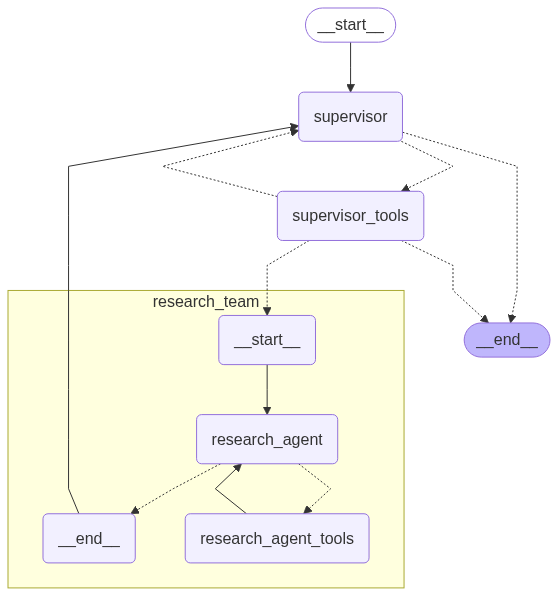

In [6]:
# Visualize the graph structure
# This shows how supervisor and research agents are connected in the workflow
display(Image(agent.get_graph(xray=1).draw_mermaid_png(max_retries=5)))